In [38]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [50]:
%%R
list.files('fastq')

[1] "Input_T1_S43_L006_R1_001.fastq.gz" "Input_T2_S44_L006_R1_001.fastq.gz"
[3] "Input_U1_S41_L006_R1_001.fastq.gz" "Input_U2_S42_L006_R1_001.fastq.gz"
[5] "IP_T1_S47_L006_R1_001.fastq.gz"    "IP_T2_S48_L006_R1_001.fastq.gz"   
[7] "IP_U1_S45_L006_R1_001.fastq.gz"    "IP_U2_S46_L006_R1_001.fastq.gz"   


I've started from bam files previously mapped by Hani or Alex. All `bam`  files renamed in this format: 
> `<treatment>.<input/m6A>.bam`

In [14]:
%%bash
cd bam/
for f in Input_*; do 
    o=${f/Input_/};o=${o/_S4[1-4].bam/.input.bam}; mv $f $o; 
done
for f in IP_*; do 
    o=${f/IP_/};o=${o/_S4[5-8].bam/.m6A.bam}; mv $f $o; 
done
cd ../

In [15]:
%%R
list.files('bam')

[1] "T1.input.bam" "T1.m6A.bam"   "T2.input.bam" "T2.m6A.bam"   "U1.input.bam"
[6] "U1.m6A.bam"   "U2.input.bam" "U2.m6A.bam"  


# Peakcalling 

## Control

Comparing to RADAR package, exomepeak also claculate coverage for only non threted samples. We used different conda `environment` for exomepeak (and it takes long time to run!!). 

In [34]:
%%R
library(exomePeak)
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')
setwd("bam/")
print (txdb)
res <- exomepeak(
    TXDB=txdb,
    IP_BAM=list.files(pattern='.m6A.bam$'),
    INPUT_BAM=list.files(pattern='.input.bam$'),
    OUTPUT_DIR='../exomepeak',
    EXPERIMENT_NAME='T_vs_U'
)
saveRDS(res, paste('../exomepeak/results.rds', sep='/'))
setwd("../")

### Plot _Guitar_ 
Now, let's draw metagene plots for control samples:
(using seprate env: `Guitar`)

In [37]:
%reload_ext rpy2.ipython

In [3]:
%%R
library(Guitar)

In [36]:
%%R
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')

In [8]:
%%R
GuitarPlot(txTxdb=txdb,stBedFiles="exomepeak/T_vs_U/peak.bed",miscOutFilePrefix='plot')

[1] "20200325200512"
[1] "There are 203835 transcripts of 58381 genes in the genome."
[1] "total 203835 transcripts extracted ..."
[1] "total 94682 transcripts left after ambiguity filter ..."
[1] "total 94682 transcripts left after check chromosome validity ..."
[1] "total 11625 mRNAs left after component length filter ..."
[1] "total 56222 ncRNAs left after ncRNA length filter ..."
[1] "generate components for all tx"
[1] "generate components for mRNA"
[1] "generate components for lncRNA"
[1] "generate chiped transcriptome"
[1] "generate coverage checking ranges for tx"
[1] "generate coverage checking ranges for mrna"
[1] "generate coverage checking ranges for ncrna"
[1] "20200325200923"
[1] "import BED file exomepeak/T_vs_U/peak.bed"
[1] "sample 10 points for Group1"
[1] "start figure plotting for tx ..."
[1] "start figure plotting for mrna ..."
[1] "start figure plotting for ncrna ..."


In [40]:
from wand.image import Image as WImage

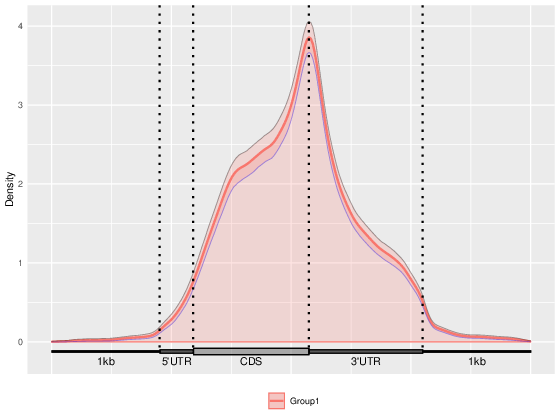

In [47]:
img = WImage(filename='plot_mrna_test.pdf', resolution=70) # bigger
img

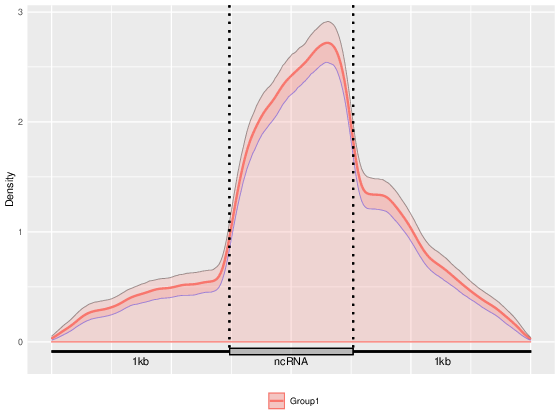

In [48]:
img = WImage(filename='plot_ncrna_test.pdf', resolution=70) # bigger
img

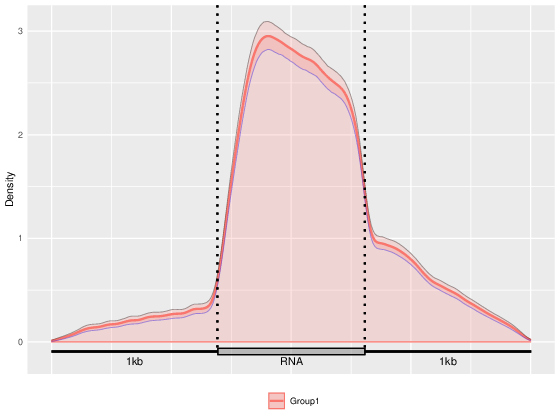

In [49]:
img = WImage(filename='plot_tx_test.pdf', resolution=70) # bigger
img

### Motif analysis 

using `cgat` env to use [CGAT - Computational Genomics Analysis Tools](https://www.cgat.org/downloads/public/cgat/documentation/) and use 

In [ ]:
%%bash 
cd ~/People/Gilbertlab/Decitabine_treatment/MeRIP-seq_treated/exomepeak/T_vs_U/
# sort | merge by name 
cat peak.bed | sort -k1,1 -k2,2n peak.bed | cgat bed2bed --method=merge --merge-by-name |  awk '! /#/' > peak.edit.bed
# get fasta for the cordinate sequnces (-split removes introns)
bedtools getfasta -name -s -fi /rumi/shams/genomes/hg38/hg38.fa -bed peak.edit.bed -split -fo peak.fa
# prepare fasta file for FIRE
perl /flash/hani/bin/Tools/prep_seqs_for_teiser_run.pl peak.fa peaks

In [36]:
%%bash 
cd ~/People/Gilbertlab/Decitabine_treatment/MeRIP-seq_treated/exomepeak/T_vs_U/
# run FIRE --doskipdiscovery=0
# nohup perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --oribiasonly=0 > skipdiscovery.0.out
mv peaks_teiser.txt_FIRE/ skipdiscovery.0_FIRE

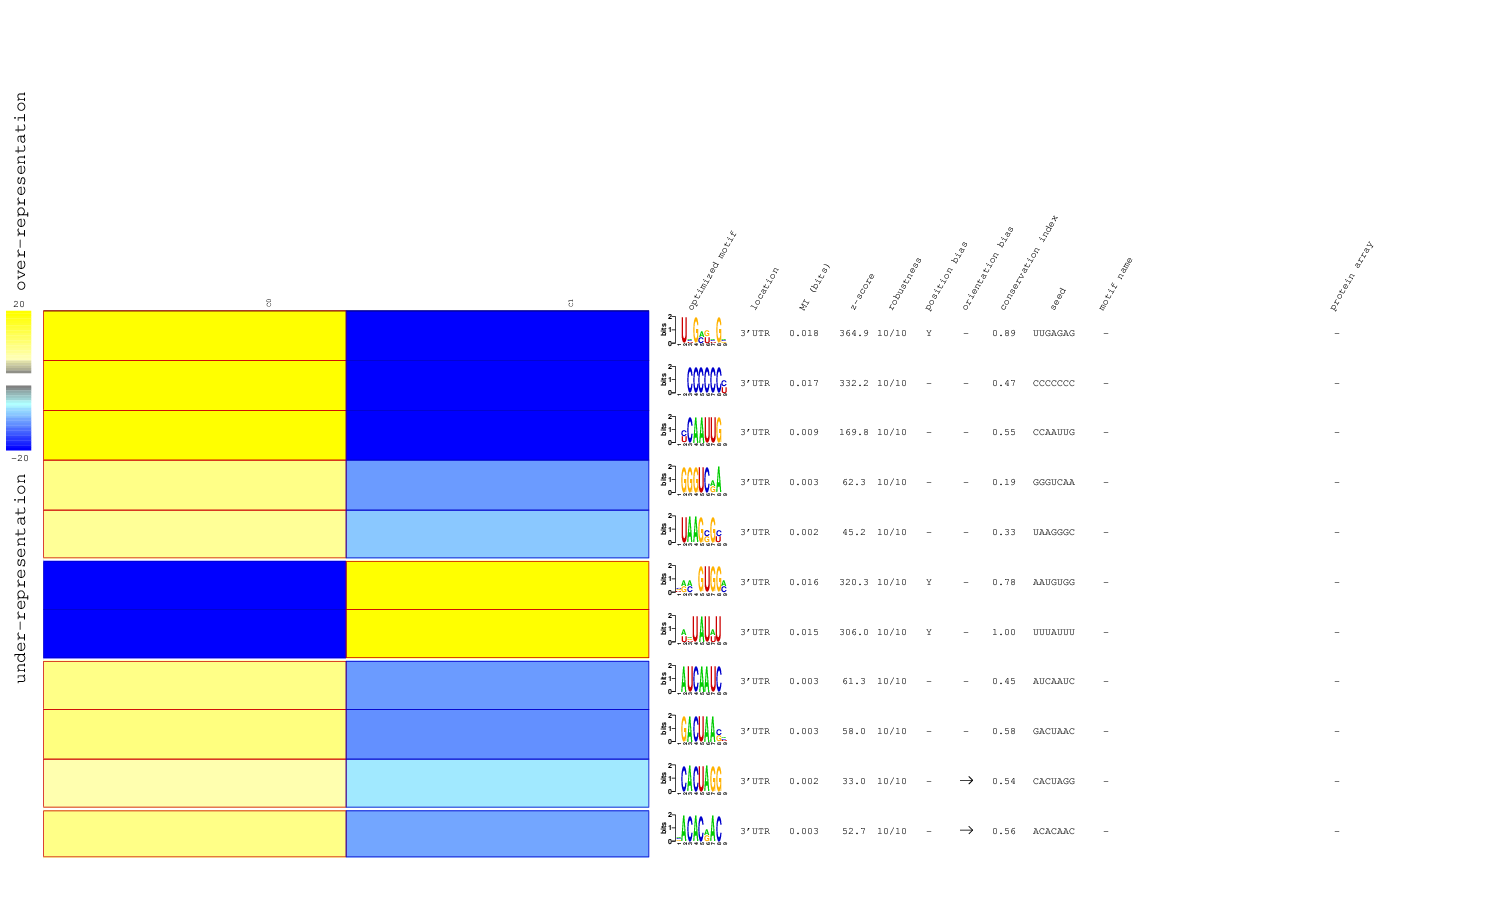

In [40]:
img = WImage(filename='/rumi/shams/abe/People/Gilbertlab/Decitabine_treatment/MeRIP-seq_treated/exomepeak/T_vs_U/skipdiscovery.0_FIRE/RNA/peaks_teiser.txt.summary.pdf', resolution=90) # bigger
img

To run `FIRE` non-discovery mode we need to list in a file like `motifs_of_interest.txt` 

In [ ]:
%%bash 
cd ~/People/Gilbertlab/Decitabine_treatment/MeRIP-seq_treated/exomepeak/T_vs_U/
# run FIRE --doskipdiscovery=1
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --doskipdiscovery=1 --motiffile_rna=motifs_of_interest.txt --oribiasonly=0
mv peaks_teiser.txt_FIRE/ skipdiscovery.1_FIRE

## Differential peaks 

using `RADAR` env 

In [2]:
# !mkdir radar

In [4]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [24]:
%%R
list.files('bam', pattern='bam$')
library("RADAR")

gtf = '/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf'
cutoff = 0.1; Beta_cutoff = 0.5;threads = 18

radar <- countReads(
    samplenames =  c('T1','T2','U1','U2'),
    gtf = gtf,
    bamFolder = "bam",
    modification = 'm6A',
    strandToKeep = "opposite",
    outputDir = 'radar',
    threads = threads,
    saveOutput = TRUE
)
saveRDS(radar, file = "radar/raw.radar.rds") # ,compress = TRUE)

Reading gtf file to obtain gene model
Filter out ambiguous model...


R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 27.7577355941137 mins... 


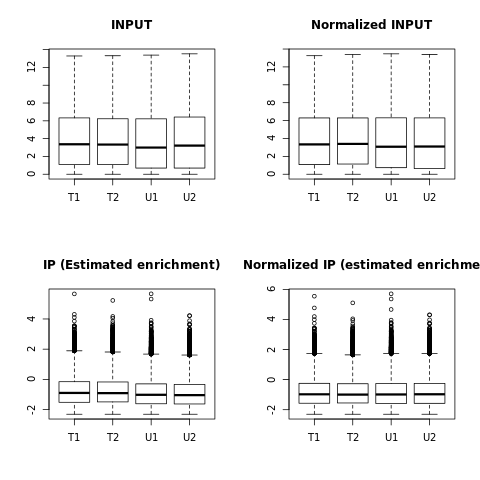

In [25]:
%%R
radar <- normalizeLibrary(radar)

In [26]:
%%R
radar <- adjustExprLevel(radar)

Adjusting expression level using Input geneSum read count...


In [27]:
%%R
radar

MeRIP.RADAR dataset of 4 samples.
Read count quantified in 50-bp consecutive bins on the transcript.
The total read count for Input and IP samples are (Million reads):
         T1    T2    U1    U2
Input 32.85 29.65 29.69 37.02
IP    42.65 44.07 37.99 36.02
Input gene level read count available.


In [30]:
%%R
variable(radar) <- data.frame( Group =c(rep("Un-treated",2),rep("Treated",2)) )
radar <- filterBins(radar,minCountsCutOff = 15)

Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...

In [31]:
%%R
radar <- diffIP_parallel(radar, thread = threads)
top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],]
radar <- reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, threads=threads)
result <- results(radar)

write.csv(results, 'radar/radar.final.bed', quote = FALSE, row.names = FALSE)
saveRDS(radar, file = "radar/radar.final.rds") # ,compress = TRUE)

The predictor variable has been converted:
Un-treated Un-treated    Treated    Treated 
         0          0          1          1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.612746115525564 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 0.6673157731692 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 4585 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


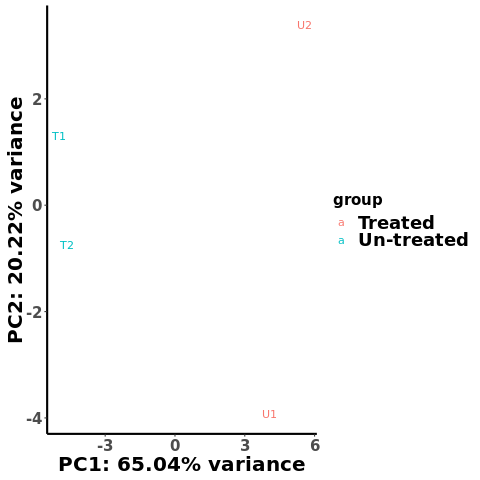

In [32]:
%%R
plotPCAfromMatrix(top_bins,group = unlist(variable(radar)) )

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


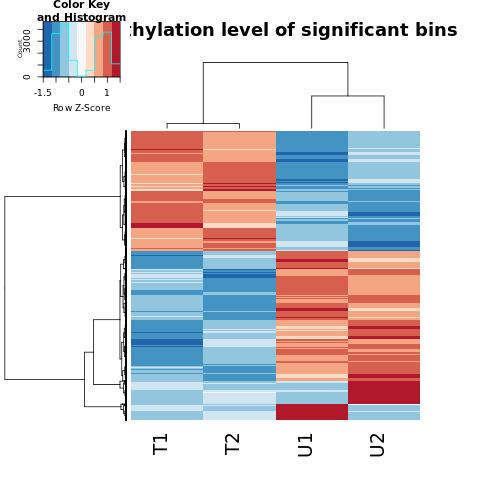

In [33]:
%%R
plotHeatMap(radar)

In [50]:
# sessionInfo()